# COMP90051 Project 2

In [44]:
# Do not edit. These are the only imports permitted.
%matplotlib inline
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

## Load dataset

In [45]:
arms = []
rewards = []
contexts = []

with open("dataset.txt", "r") as f:
    for line in f:
        row = line[:-2].split(" ")
        arms.append(int(row[0]))
        rewards.append(int(row[1]))
        contexts.append(np.array(row[2:], dtype='float64'))
        
# convert all into numpy arrays
arms = np.array(arms)
rewards = np.array(rewards, dtype='float64')
contexts = np.array(contexts, dtype='float64')

## 1. Implementing ε-Greedy and UCB

In [3]:
class MAB(ABC):
    """
    Abstract class that represents a multi-armed bandit (MAB)
    """
    
    @abstractmethod
    def play(self, tround, context):
        """
        Play a round
        
        Arguments
        =========
        tround : int
            positive integer identifying the round
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to the arms
        
        Returns
        =======
        arm : int
            the positive integer arm id for this round
        """
    
    @abstractmethod
    def update(self, arm, reward, context):
        """
        Updates the internal state of the MAB after a play
        
        Arguments
        =========
        arm : int
            a positive integer arm id in {1, ..., self.narms}
        
        reward : float
            reward received from arm
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to arms
        """

In [4]:
class EpsGreedy(MAB): # sub-class of abstract MAB base class
    """
    Epsilon-Greedy multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    epsilon : float
        explore probability

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, epsilon, Q0=np.inf):
        # check types and values
        assert np.issubdtype(type(narms), np.integer) and narms >= 1, \
        "invalid narms, must be integer >= 1"
        assert np.issubdtype(type(epsilon), np.floating) and epsilon >= 0 and epsilon <= 1, \
        "invalid epsilon, must be float between 0 and 1"
        assert np.issubdtype(type(Q0), np.floating), \
        "invalid Q0, must be float"
        
        # store params
        self.narms = narms
        self.epsilon = epsilon
        self.Q0 = Q0
        self.rewards = {}
        
        # initialise observed rewards as empty lists
        for i in range(1, narms + 1):
            self.rewards[i] = []
        
    def play(self, tround, context=None):
        # check types and values
        assert np.issubdtype(type(tround), np.integer) and tround >= 1, \
        "invalid tround, must be integer >= 1"
        
        # random number between 0 and 1
        choice = np.random.random()
        
        if choice < self.epsilon:
            # explore
            return np.random.randint(1, self.narms + 1)
        else:
            # average reward for each arm
            avg_rewards = {}  
            for i in range(1, self.narms + 1):
                if len(self.rewards[i]) == 0:  # never pulled
                    # initial reward
                    avg_rewards[i] = self.Q0
                else:
                    # get average
                    avg_rewards[i] = np.mean(self.rewards[i])
            
            # exploit
            max_item = max(avg_rewards.items(), key=lambda x : x[1])
            
            # find all arms with max avg rewards
            all_keys = []
            for key, value in avg_rewards.items():
                if value == max_item[1]:
                    all_keys.append(key)
            
            # break tie randomly
            return np.random.choice(all_keys)
        
    def update(self, arm, reward, context=None):
        # check types and values
        assert np.issubdtype(type(arm), np.integer) and arm >= 1 and arm <= self.narms, \
        "invalid arm, must be integer in {1,...,self.narms}"
        assert np.issubdtype(type(reward), np.floating) and (reward == 0 or reward == 1), \
        "invalid reward, must be float 0.0 or 1.0"
        
        # record rewards
        self.rewards[arm].append(reward)

In [5]:
class UCB(MAB):
    """
    Upper Confidence Bound (UCB) multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    rho : float
        positive real explore-exploit parameter

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, rho, Q0=np.inf):        
        # check types and values
        assert np.issubdtype(type(narms), np.integer) and narms >= 1, \
        "invalid narms, must be integer >= 1"
        assert np.issubdtype(type(rho), np.floating) and rho > 0, \
        "invalid rho, must be float > 0"
        assert np.issubdtype(type(Q0), np.floating), \
        "invalid Q0, must be float"
        
        # store params
        self.narms = narms
        self.rho = rho
        self.Q0 = Q0
        self.rewards = {}
        
        # initialise observed rewards as empty lists
        for i in range(1, narms + 1):
            self.rewards[i] = []
    
    def play(self, tround, context=None):
        # check types and values
        assert np.issubdtype(type(tround), np.integer) and tround >= 1, \
        "invalid tround, must be integer >= 1"
        
        # UCBs for each arm
        UCBs = {}
        for i in range(1, self.narms + 1):
            if len(self.rewards[i]) == 0:  # never pulled
                # initial reward
                UCBs[i] = self.Q0
            else:
                # calculate UCBs
                UCBs[i] = np.mean(self.rewards[i]) + np.sqrt(self.rho * np.log(tround) / len(self.rewards[i]))
        
        # exploit
        max_item = max(UCBs.items(), key=lambda x : x[1])

        # find all arms with max UCBs
        all_keys = []
        for key, value in UCBs.items():
            if value == max_item[1]:
                all_keys.append(key)

        # break tie randomly
        return np.random.choice(all_keys)
        
        
    def update(self, arm, reward, context=None):
        # check types and values
        assert np.issubdtype(type(arm), np.integer) and arm >= 1 and arm <= self.narms, \
        "invalid arm, must be integer in {1,...,self.narms}"
        assert np.issubdtype(type(reward), np.floating) and (reward == 0 or reward == 1), \
        "invalid reward, must be float 0.0 or 1.0"
        
        # record rewards
        self.rewards[arm].append(reward)


## 2. The Basic Thompson Bandit

In [6]:
class BetaThompson(MAB):
    """
    Beta-Bernoulli Thompson sampling multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    alpha0 : float, optional
        positive real prior hyperparameter

    beta0 : float, optional
        positive real prior hyperparameter
    """
    
    def __init__(self, narms, alpha0=1.0, beta0=1.0):
        # check types and values
        assert np.issubdtype(type(narms), np.integer) and narms >= 1, \
        "invalid narms, must be integer >= 1"
        assert np.issubdtype(type(alpha0), np.floating) and alpha0 > 0, \
        "invalid alpha0, must be float > 0"
        assert np.issubdtype(type(beta0), np.floating) and beta0 > 0, \
        "invalid beta0, must be float > 0"
        
        # store params
        self.alpha0 = alpha0
        self.beta0 = beta0
        self.narms = narms
        self.S = {}  # num of successes for each arm
        self.F = {}  # num of failures for each arm
        
        # initialise S and F for each arm as 0
        for i in range(1, narms + 1):
            self.S[i] = 0
            self.F[i] = 0
    
    def play(self, tround, context=None):
        # check types and values
        assert np.issubdtype(type(tround), np.integer) and tround >= 1, \
        "invalid tround, must be integer >= 1"
        
        # get samples from each distribution
        theta = {}
        for i in range(1, self.narms + 1):    
            theta[i] = np.random.beta(self.alpha0 + self.S[i], self.beta0 + self.F[i])
            
        # exploit
        max_item = max(theta.items(), key=lambda x : x[1])

        # find all arms with max thetas
        all_keys = []
        for key, value in theta.items():
            if value == max_item[1]:
                all_keys.append(key)

        return np.random.choice(all_keys)
        
    def update(self, arm, reward, context=None):
        # check types and values
        assert np.issubdtype(type(arm), np.integer) and arm >= 1 and arm <= self.narms, \
        "invalid arm, must be integer in {1,...,self.narms}"
        assert np.issubdtype(type(reward), np.floating) and (reward == 0 or reward == 1), \
        "invalid reward, must be float 0.0 or 1.0"
        
        if reward == 1:
            self.S[arm] += 1
        else:
            self.F[arm] += 1

## 3. Off-Policy Evaluation

In [7]:
def offlineEvaluate(mab, arms, rewards, contexts, nrounds=None):
    """
    Offline evaluation of a multi-armed bandit
    
    Arguments
    =========
    mab : instance of MAB
    
    arms : 1D int array, shape (nevents,) 
        integer arm id for each event
    
    rewards : 1D float array, shape (nevents,)
        reward received for each event
    
    contexts : 2D float array, shape (nevents, mab.narms*nfeatures)
        contexts presented to the arms (stacked horizontally) 
        for each event.
        
    nrounds : int, optional
        number of matching events to evaluate `mab` on.
    
    Returns
    =======
    out : 1D float array
        rewards for the matching events
    """
    
    # check types and values
    assert isinstance(mab, MAB), \
    "invalid mab, must be an instance of class MAB"
    
    assert isinstance(arms, np.ndarray) and np.issubdtype(arms.dtype, np.integer) \
    and len(arms.shape) == 1, \
    "invalid arms type, must be instance of 1D numpy.ndarray with integer elements"
    
    assert isinstance(rewards, np.ndarray) and np.issubdtype(rewards.dtype, np.floating) \
    and len(rewards.shape) == 1, \
    "invalid rewards type, must be instance of 1D numpy.ndarray with floating elements"
    
    assert isinstance(contexts, np.ndarray) and np.issubdtype(contexts.dtype, np.floating) \
    and len(contexts.shape) == 2, \
    "invalid contexts type, must be instance of 2D numpy.ndarray with floating elements"
    
    assert np.issubdtype(type(nrounds), np.integer) and nrounds >= 1, \
    "invalid nrounds type, must be integer >= 1"
    
    stream_idx = -1
    nevents = len(rewards) # num of logged events
    mab_rewards = []
    
    # use all logged events if nrounds is None
    if nrounds == None:
        nrounds = nevents
        
    # play each round
    for tround in range(1, nrounds + 1):
        
        # get next event
        stream_idx += 1
        if stream_idx >= nevents:  # reach end
            return mab_rewards
        
        selected_arm = mab.play(tround, contexts[stream_idx])
        
        # play until both policies get same arm
        while(selected_arm != arms[stream_idx]):
            
            # get next event
            stream_idx += 1
            if stream_idx >= nevents:  # reach end
                return mab_rewards
            
            # play again
            selected_arm = mab.play(tround, contexts[stream_idx])
        
        # update history and store reward
        mab.update(arms[stream_idx], rewards[stream_idx], contexts[stream_idx])
        mab_rewards.append(rewards[stream_idx])
        
    return mab_rewards

In [8]:
mab = EpsGreedy(10, 0.05)
results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))

EpsGreedy average reward 0.27


In [9]:
mab = UCB(10, 1.0)
results_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('UCB average reward', np.mean(results_UCB))

UCB average reward 0.1475


In [10]:
mab = BetaThompson(10, 1.0, 1.0)
results_BetaThompson = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('BetaThompson average reward', np.mean(results_BetaThompson))

BetaThompson average reward 0.2225


## 4. Contextual Bandits - LinUCB

In [11]:
class LinUCB(MAB):   # with disjoint linear models (for each arm)
    """
    Contextual multi-armed bandit (LinUCB)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    alpha : float
        positive real explore-exploit parameter
    """
    
    def __init__(self, narms, ndims, alpha):
        # check types and values
        assert np.issubdtype(type(narms), np.integer) and narms >= 1, \
        "invalid narms, must be integer >= 1"
        assert np.issubdtype(type(ndims), np.integer) and ndims >= 1, \
        "invalid ndims, must be integer > 0"
        assert np.issubdtype(type(alpha), np.floating) and alpha > 0, \
        "invalid alpha, must be float > 0"
        
        # store params
        self.narms = narms
        self.ndims = ndims
        self.alpha = alpha
        
        # params for each arm
        self.A = {}
        self.b = {}
        
        # initialise
        for i in range(1, narms + 1):
            self.A[i] = np.identity(ndims)
            self.b[i] = np.zeros(ndims).reshape(ndims, 1)  # as a column vector
        
    def play(self, tround, context):
        # check types and values
        assert np.issubdtype(type(tround), np.integer) and tround >= 1, \
        "invalid tround, must be integer >= 1"
        assert isinstance(context, np.ndarray) and context.shape == (self.narms * self.ndims,), \
        "invalid context, must be instance of numpy.ndarray with length narms * ndims"
        
        contexts = context.reshape(self.narms, self.ndims)
        
        # calculate UCB for each arm
        UCBs = {}
        for i in range(1, self.narms + 1):
            # context for arm i
            arm_context = contexts[i-1].reshape(self.ndims, 1)
            
            theta = np.dot(inv(self.A[i]),self.b[i])  # coefficients
            estimate = np.dot(theta.T, arm_context)
            ci_width = self.alpha * np.sqrt(np.dot(arm_context.T, inv(self.A[i])).dot(arm_context))
            UCBs[i] = (estimate + ci_width)[0][0]  # convert matrix with one element only into that value
                
        # exploit
        max_item = max(UCBs.items(), key=lambda x : x[1])

        # find all arms with max UCBs
        all_keys = []
        for key, value in UCBs.items():
            if value == max_item[1]:
                all_keys.append(key)

        # break tie randomly
        return np.random.choice(all_keys)
        
    def update(self, arm, reward, context):
        # check types and values
        assert np.issubdtype(type(arm), np.integer) and arm >= 1 and arm <= self.narms, \
        "invalid arm, must be integer in {1,...,self.narms}"
        assert np.issubdtype(type(reward), np.floating) and (reward == 0 or reward == 1), \
        "invalid reward, must be float 0.0 or 1.0"
        assert isinstance(context, np.ndarray) and context.shape == (self.narms * self.ndims,), \
        "invalid context, must be instance of numpy.ndarray with length narms * ndims"
        
        contexts = context.reshape(self.narms, self.ndims)
        arm_context = contexts[arm-1].reshape(self.ndims, 1)
        
        # update matrix A and vector b
        self.A[arm] += np.dot(arm_context, arm_context.T)
        self.b[arm] += reward*arm_context
        

In [12]:
mab = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinUCB average reward', np.mean(results_LinUCB))

LinUCB average reward 0.53


## 5. Contextual Bandits - LinThompson

In [13]:
class LinThompson(MAB):
    """
    Contextual Thompson sampled multi-armed bandit (LinThompson)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    v : float
        positive real explore-exploit parameter
    """
    
    def __init__(self, narms, ndims, v):
        # check types and values
        assert np.issubdtype(type(narms), np.integer) and narms >= 1, \
        "invalid narms, must be integer >= 1"
        assert np.issubdtype(type(ndims), np.integer) and ndims >= 1, \
        "invalid ndims, must be integer > 0"
        assert np.issubdtype(type(v), np.floating) and v > 0, \
        "invalid v, must be float > 0"
        
        # store params
        self.narms = narms
        self.ndims = ndims
        self.v = v
        
        # initialisation
        self.B = np.identity(ndims)
        self.mu_hat = np.zeros(ndims).reshape(ndims, 1)
        self.f = np.zeros(ndims).reshape(ndims, 1)
        
    def play(self, tround, context):
        # check types and values
        assert np.issubdtype(type(tround), np.integer) and tround >= 1, \
        "invalid tround, must be integer >= 1"
        assert isinstance(context, np.ndarray) and context.shape == (self.narms * self.ndims,), \
        "invalid context, must be instance of numpy.ndarray with length narms * ndims"
        
        contexts = context.reshape(self.narms, self.ndims)
        
        # sampling from multivariate normal distribution
        mu_sample = np.random.multivariate_normal(self.mu_hat.reshape(self.ndims,), (self.v**2)*inv(self.B))
        
        # get estimates of rewards
        estimates = {}
        for i in range(1, self.narms + 1):
            arm_context = contexts[i-1].reshape(self.ndims, 1)
            estimates[i] = np.dot(arm_context.T, mu_sample)
        
        # exploit
        max_item = max(estimates.items(), key=lambda x : x[1])

        # find all arms with max thetas
        all_keys = []
        for key, value in estimates.items():
            if value == max_item[1]:
                all_keys.append(key)

        # break tie randomly
        return np.random.choice(all_keys) 
    
    def update(self, arm, reward, context):
        # check types and values
        assert np.issubdtype(type(arm), np.integer) and arm >= 1 and arm <= self.narms, \
        "invalid arm, must be integer in {1,...,self.narms}"
        assert np.issubdtype(type(reward), np.floating) and (reward == 0 or reward == 1), \
        "invalid reward, must be float 0.0 or 1.0"
        assert isinstance(context, np.ndarray) and context.shape == (self.narms * self.ndims,), \
        "invalid context, must be instance of numpy.ndarray with length narms * ndims"
        
        contexts = context.reshape(self.narms, self.ndims)
        arm_context = contexts[arm-1].reshape(self.ndims, 1)
        
        # update values
        self.B += np.dot(arm_context, arm_context.T)
        self.f += arm_context*reward
        self.mu_hat = np.dot(inv(self.B), self.f)


In [14]:
mab = LinThompson(10, 10, 1.0)
results_LinThompson = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinThompson average reward', np.mean(results_LinThompson))

LinThompson average reward 0.31875


## 6. Evaluation
### 6.A.

In [15]:
def per_round_cumulative(results):
    
    cumulative_award = []
    
    for i in range(1, len(results) + 1):
        cumulative_award.append(np.mean(results[:i]))  # cumulative 
        
    return cumulative_award

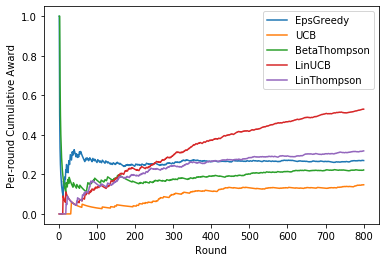

In [16]:
x = [i for i in range(1, len(results_LinThompson) + 1)]

# use previous results
y_EpsGreedy = per_round_cumulative(results_EpsGreedy)
y_UCB = per_round_cumulative(results_UCB)
y_BetaThompson = per_round_cumulative(results_BetaThompson)
y_LinUCB = per_round_cumulative(results_LinUCB)
y_LinThompson = per_round_cumulative(results_LinThompson)

# plot curves
plt.plot(x, y_EpsGreedy, label = "EpsGreedy")
plt.plot(x, y_UCB, label = "UCB")
plt.plot(x, y_BetaThompson, label = "BetaThompson")
plt.plot(x, y_LinUCB, label = "LinUCB")
plt.plot(x, y_LinThompson, label = "LinThompson")

# labels
plt.xlabel("Round")
plt.ylabel("Per-round Cumulative Award")
plt.legend()
plt.show()

### 6.B.

## LinUCB
From the WWW’2010 paper, the author used grid search to find the best value for alpha in 0 to 1.5. Therefore, same range is used over here for tunning.

In [39]:
def linUCB_eval(alphas):
    # rewards for different alphas
    linUCB_rewards = []
    for alpha in alphas:
        mab = LinUCB(10, 10, alpha)
        results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
        linUCB_rewards.append(np.mean(results_LinUCB))
        
    # plot results
    plt.plot(alphas, linUCB_rewards)
    plt.xlabel("alpha")
    plt.ylabel("LinUCB average reward")
    plt.show()
    
    return linUCB_rewards

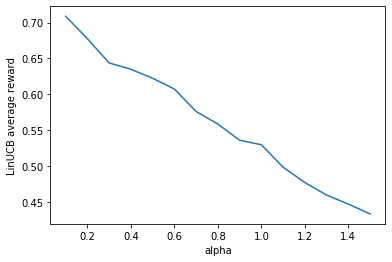

In [32]:
# initial grid search for LinUCB
alphas = np.arange(0.1, 1.6, 0.1)
linUCB_rewards = linUCB_eval(alphas)

It seems that the best alpha for LinUCB lies between 0.0 and 0.2 (exclusive), we can use grid search again to find a better value for alpha.

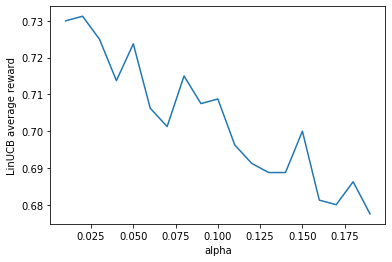

In [33]:
alphas = np.arange(0.01, 0.2, 0.01)
linUCB_rewards = linUCB_eval(alphas)

Then we can try the values from 0.01 to 0.03 (exclusive)

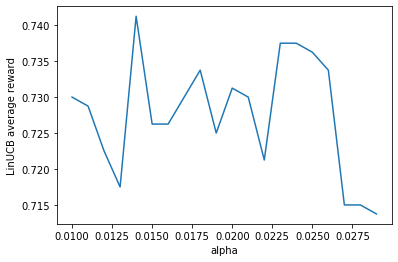

Best alpha value for LinUCB:  0.013999999999999997
Best reward:  0.74125


In [40]:
# initial grid search for LinUCB
alphas = np.arange(0.01, 0.03, 0.001)
linUCB_rewards = linUCB_eval(alphas)
print("Best alpha value for LinUCB: ", alphas[np.argmax(linUCB_rewards)])
print("Best reward: ", max(linUCB_rewards))

In conclusion, the best value for alpha is 0.014 with max reward 0.74125

## LinThmpson
We should first find a reasonable range for v by tring various values, and since LinThmpson has randomness, it may be better to take average of multiple results to evaluate.

In [49]:
def linThompson_eval(vs):
    # rewards for different alphas
    linThompson_rewards = []
    
    for v in vs:
        # repeat 5 times and take average score for each value of alpha
        scores = []
        for i in range(5):
            mab = LinThompson(10, 10, v)
            scores.append(np.mean(offlineEvaluate(mab, arms, rewards, contexts, 800)))
        linThompson_rewards.append(np.mean(scores))
        
    # plot results
    plt.plot(vs, linThompson_rewards)
    plt.xlabel("v")
    plt.ylabel("LinThompson average reward")
    plt.show()
    
    return linThompson_rewards

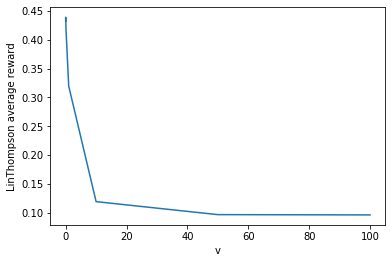

In [55]:
# initial grid search for LinThompson
vs = [1e-3, 1e-2, 1e-1, 1.0, 10.0, 50.0, 100.0]
linThompson_rewards = linThompson_eval(vs)

It seems that the best v for LinThompson is very small, and it lies between 0.0 and 5.0 (exclusive), we can use grid search again to find a better value for v.

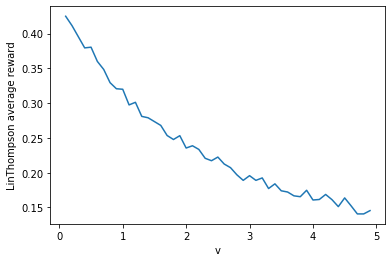

In [56]:
# grid search for LinThompson
vs = np.arange(0.1, 5.0, 0.1)
linThompson_rewards = linThompson_eval(vs)

We can do this again for interval between 0.0 and 0.5 (exclusive)

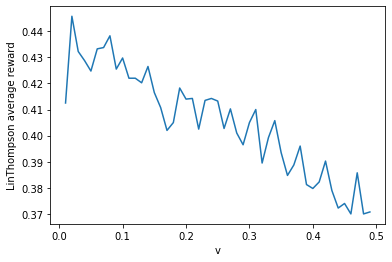

In [57]:
# grid search for LinThompson
vs = np.arange(0.01, 0.5, 0.01)
linThompson_rewards = linThompson_eval(vs)

Then, try v between 0.0 and 0.1 (exclusive)

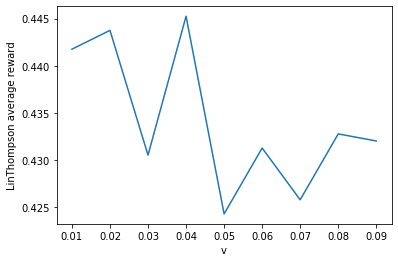

Best v value for LinThompson:  0.04
Best reward:  0.44525


In [61]:
# grid search for LinThompson
vs = np.arange(0.01, 0.1, 0.01)
linThompson_rewards = linThompson_eval(vs)
print("Best v value for LinThompson: ", vs[np.argmax(linThompson_rewards)])
print("Best reward: ", max(linThompson_rewards))

In conclusion, the best value for v is 0.04 with best reward 0.44525